In [1]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
G = nx.read_edgelist('./vidal_tsv')

# Visualization

In [3]:
# remove self-loops
self_loops = [(u, v) for u, v in G.edges() if u == v]
G.remove_edges_from(self_loops)

In [21]:
# drawing function
def draw(G:nx.Graph, k=0.2, node_size=10, width=0.2, file_name='example.png', **kwargs):
    plt.figure(figsize=(15, 15)) 

    options = {
        "node_size": node_size, 
        "linewidths": 0.2, 
        "width": width,
        **kwargs,
    }
    pos = nx.spring_layout(G, k=k,seed=42)

    nx.draw_networkx(G, pos=pos, with_labels=False, **options)
    plt.savefig(file_name)
    plt.show()
    


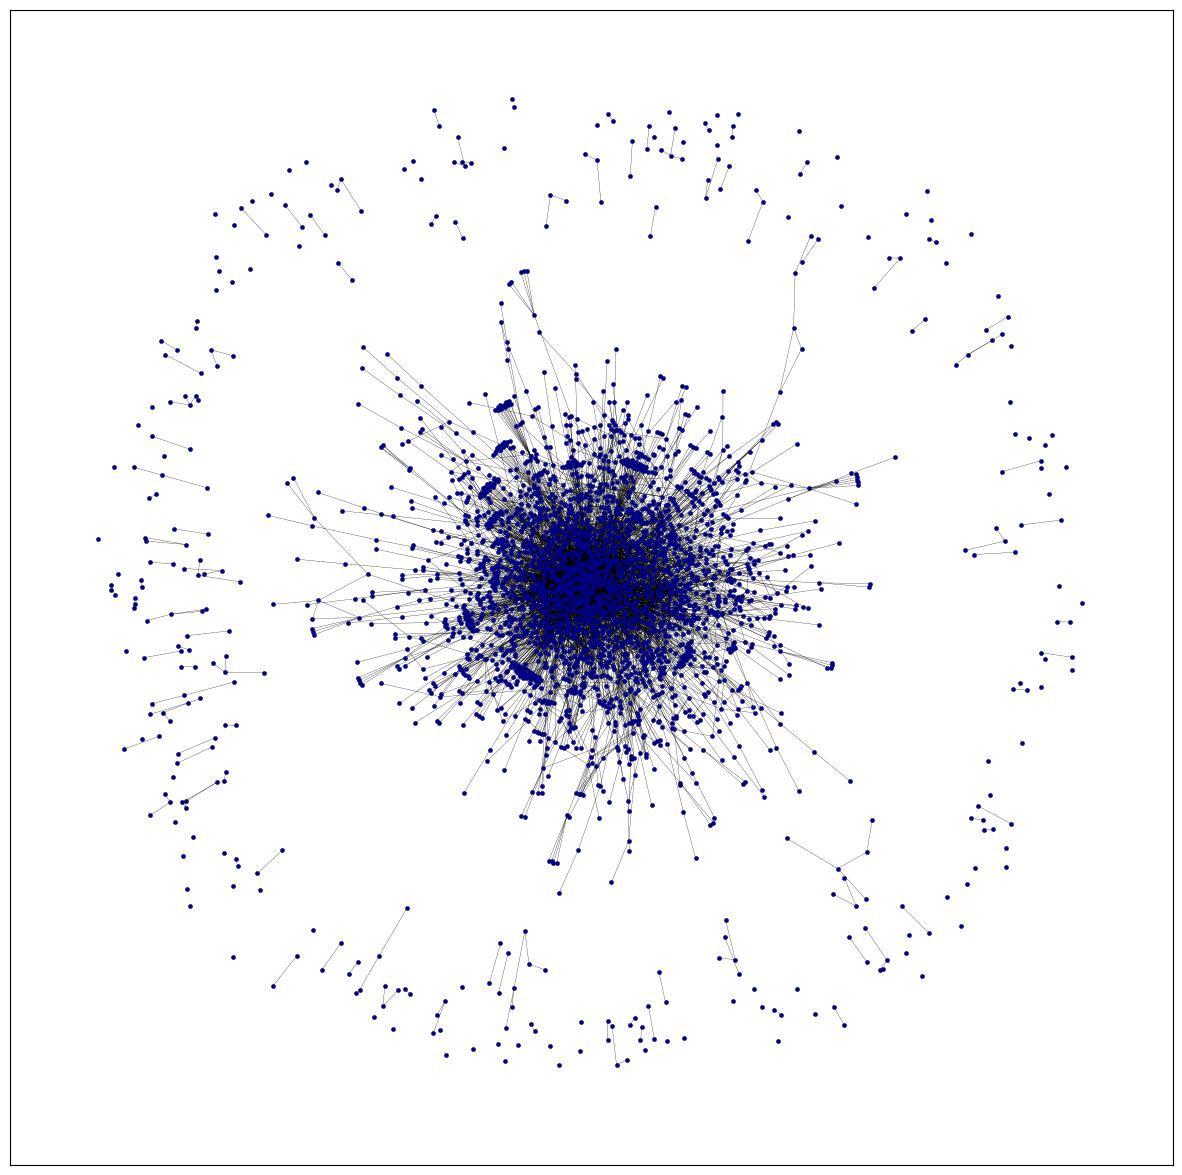

In [22]:
draw(G, k=0.04,file_name='lcc.png', node_color='navy')

⬆️ Obviously there's a big CC in the middle and a bunch of isolated points on the periphery, so i decide to remove these peripheral points first.

In [47]:
# Extract the Largest CC

connected_components = list(nx.connected_components(G))
largest_connected_component = max(connected_components, key=len)
G_lcc = G.subgraph(largest_connected_component)

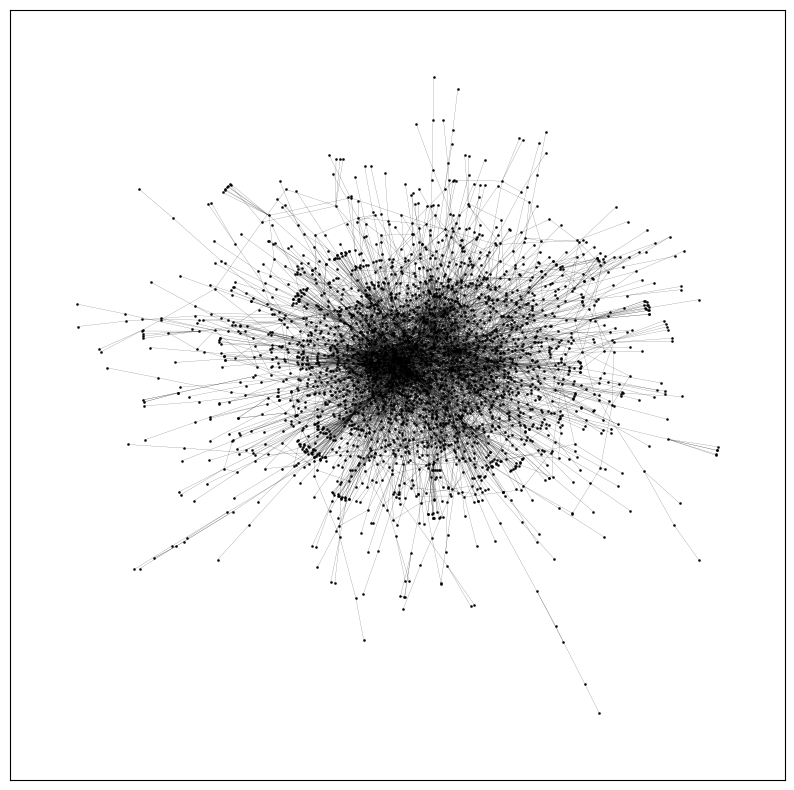

In [79]:
draw(G_lcc, node_color='black')

# Spectral Clustering

In [105]:
# Laplacian 

# nx.adjacency_matrix() will return a `scipy.sparse` array
A = nx.adjacency_matrix(G_lcc).toarray()

# construct W (degree diagnol matrix)
degree_sequence = [degree for node, degree in G_lcc.degree()]
W = np.diag(degree_sequence)

L = W - A

/var/folders/r_/c2lk8b9s5qb2tpb3ql4jzh100000gn/T/ipykernel_64206/579050468.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G_lcc).toarray()


In [146]:
# Eigendecomposition
from scipy.sparse.linalg import eigs
from scipy.linalg import eig

# this is for compatibility with `eigs` function
L = L.astype('float64')

K = 5

vals, vecs = eigs(L, k=K, sigma=0)
# vals, vecs = eig(L)
print(vecs.shape)

(2783, 5)


In [138]:
sorted_vals = np.sort(vals)

/Users/keniwo/opt/anaconda3/envs/mle/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


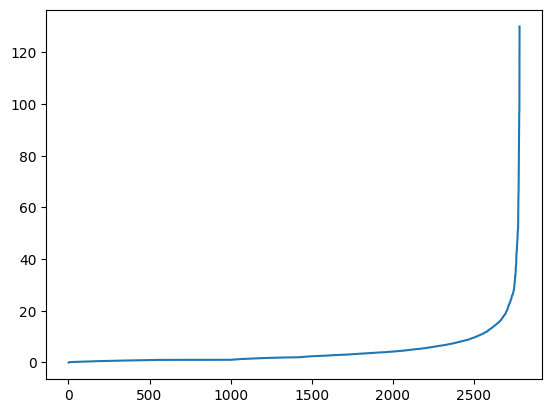

In [139]:
plt.plot(np.arange(1, len(vals)+1), sorted_vals)

In [147]:
from sklearn.cluster import KMeans

# turn complex values to real
vecs = vecs.real
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(vecs)

# count the num from labels
cluster_labels = kmeans.labels_
cluster_counts = np.bincount(cluster_labels)


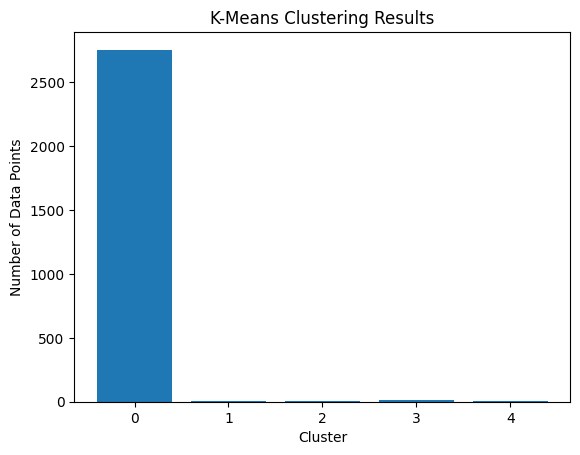

In [148]:
plt.bar(range(K), cluster_counts, tick_label=range(K))

# Add labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.title("K-Means Clustering Results")

# Show the plot
plt.show()

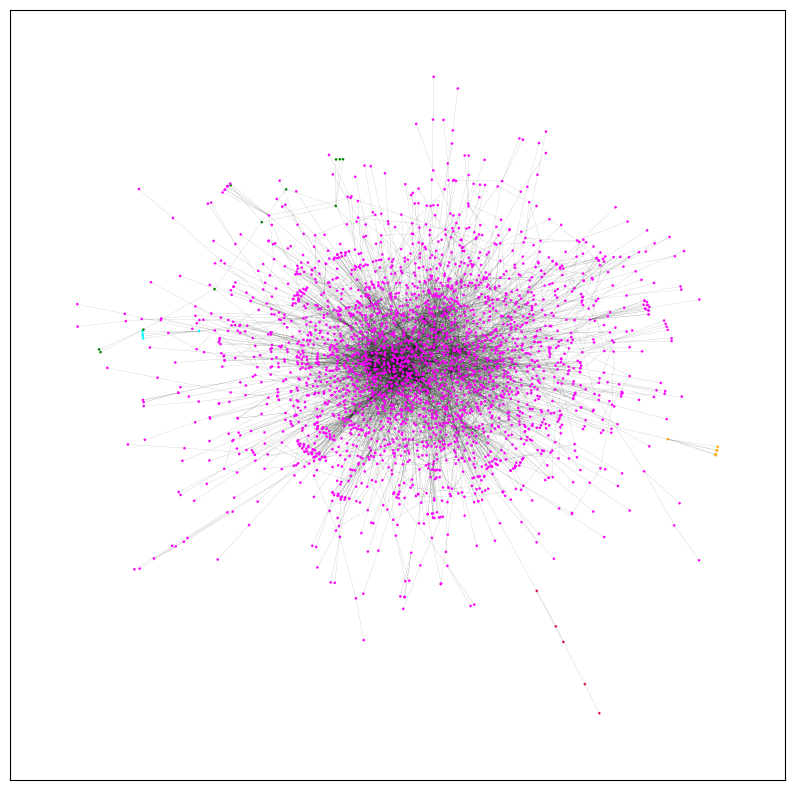

In [149]:
color_map = {
    0: 'magenta',
    1: 'cyan',
    2: 'orange',
    3: 'green',
    4: 'crimson'
}

color_list = [color_map[label] for label in cluster_labels]
draw(G_lcc, width=0.05, node_color=color_list)